In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf


import librosa, librosa.display, os

# Loading the waveforms and creating a labels array

In [2]:
#list of waveform lists to be loaded by librosa.load()
waveforms = []
sample_rates = []
# list of lists containing the target labels for the lists in [waveforms]
labels = []


cur_dir = "Philharmonia/" 

for filename in os.listdir(cur_dir):
    if(filename[0]=='.'):
        continue
    y, sr = librosa.load(cur_dir + "/" + filename)
    waveforms.append(y)
    sample_rates.append(sr)
    labels.append(int(filename[:3]))

In [3]:
SR = sample_rates[0]

In [4]:
clip_lens = []
for waveform in waveforms:
    clip_lens.append(len(waveform))

In [5]:
count = 0
for length in clip_lens:
    if length > 11025:
        count += 1
print(count)

12267


In [6]:
shortened_wvf = []
shortened_labels = []
count = 0

for wvf in waveforms:
    if len(wvf) >= 11025:
        shortened_wvf.append(wvf[:11025])
        shortened_labels.append(labels[count])
    count += 1
len(shortened_wvf)

12267

# Reformating labels/waveforms

In [7]:
from tensorflow.keras.utils import to_categorical

cat_labels = to_categorical(shortened_labels)

In [8]:
shortened_wvf = np.asarray(shortened_wvf)
cat_labels = np.asarray(cat_labels)

In [9]:
np.save("shortened_wvf",shortened_wvf)
np.save("cat_labels",cat_labels)

Can start from next cell if already ran this once. 

In [10]:
shortened_wvf = np.load("shortened_wvf.npy")
cat_labels = np.load("cat_labels.npy")

# Turning waveforms into dB scaled spectrograms

In [11]:
mel_spectrograms = []

for wvf in shortened_wvf:
    mel_spectrograms.append(librosa.feature.melspectrogram(wvf,SR,
                                                           n_fft=512,hop_length=256, power=1))
#DO NOT convert to dB 

a = mel_spectrograms

mel_spectrograms = np.asarray(mel_spectrograms)
b = mel_spectrograms    
mel_spect_shape = list(mel_spectrograms.shape)
mel_spect_shape.append(1)

mel_spectrograms = mel_spectrograms.reshape(mel_spect_shape)

In [12]:
mel_spect_shape


[12267, 128, 44, 1]

/Users/snyder/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/snyder/opt/anaconda3/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


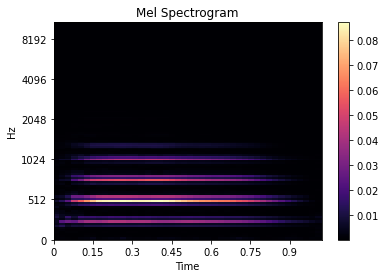

In [42]:
librosa.display.specshow(mel_spectrograms[150].reshape(mel_spect_shape[1:-1]),
                         y_axis='mel',  x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar()

## Separating Test Data

In [14]:
mel_spectrograms.shape

(12267, 128, 44, 1)

In [15]:
cat_labels[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mel_spectrograms, cat_labels, test_size=0.20, random_state=42)

In [17]:
X_train.shape

(9813, 128, 44, 1)

In [18]:
X_test.shape

(2454, 128, 44, 1)

In [19]:
y_train.shape

(9813, 17)

In [20]:
y_test.shape

(2454, 17)

## Model Creation

In [21]:
mel_spect_shape[1:]

[128, 44, 1]

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
model = Sequential()

In [31]:
#90% acc time convoluting
model.add(Conv2D(input_shape=mel_spect_shape[1:],
                filters=128,kernel_size=(1,4),
                activation="relu"
                ))
model.add(MaxPool2D(pool_size=(1,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(1,4),
                activation="relu"))
model.add(MaxPool2D(pool_size=(1,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=1, kernel_size=(1,4),
                activation="relu"))
model.add(MaxPool2D(pool_size=(1,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(17,activation="softmax"))

In [32]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 41, 128)      640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 20, 128)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 20, 128)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 17, 32)       16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 8, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 8, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 5, 1)        

In [34]:
EarlyStop = EarlyStopping(monitor="val_loss",patience=5)

In [51]:
model.fit(X_train,y_train,epochs=100,batch_size=400,validation_data=(X_test,y_test))

Epoch 1/100
25/25 [==============================] - 42s 2s/step - loss: 0.6164 - accuracy: 0.8012 - val_loss: 0.3935 - val_accuracy: 0.8810
Epoch 2/100
25/25 [==============================] - 44s 2s/step - loss: 0.5889 - accuracy: 0.8119 - val_loss: 0.3893 - val_accuracy: 0.8810
Epoch 3/100
25/25 [==============================] - 42s 2s/step - loss: 0.6106 - accuracy: 0.8066 - val_loss: 0.3539 - val_accuracy: 0.8965
Epoch 4/100
25/25 [==============================] - 42s 2s/step - loss: 0.6120 - accuracy: 0.8040 - val_loss: 0.3856 - val_accuracy: 0.8818
Epoch 5/100
25/25 [==============================] - 42s 2s/step - loss: 0.6067 - accuracy: 0.8007 - val_loss: 0.3629 - val_accuracy: 0.8835
Epoch 6/100
25/25 [==============================] - 42s 2s/step - loss: 0.6085 - accuracy: 0.8094 - val_loss: 0.3897 - val_accuracy: 0.8818
Epoch 7/100
25/25 [==============================] - 42s 2s/step - loss: 0.6100 - accuracy: 0.8026 - val_loss: 0.3967 - val_accuracy: 0.8773
Epoch 8/100
2

Epoch 59/100
25/25 [==============================] - 100s 4s/step - loss: 0.5608 - accuracy: 0.8195 - val_loss: 0.3452 - val_accuracy: 0.8965
Epoch 60/100
25/25 [==============================] - 100s 4s/step - loss: 0.5768 - accuracy: 0.8158 - val_loss: 0.3431 - val_accuracy: 0.8985
Epoch 61/100
25/25 [==============================] - 100s 4s/step - loss: 0.5644 - accuracy: 0.8145 - val_loss: 0.3433 - val_accuracy: 0.8936
Epoch 62/100
25/25 [==============================] - 7279s 303s/step - loss: 0.5709 - accuracy: 0.8162 - val_loss: 0.3464 - val_accuracy: 0.8957
Epoch 63/100
25/25 [==============================] - 4581s 191s/step - loss: 0.5656 - accuracy: 0.8198 - val_loss: 0.3363 - val_accuracy: 0.9026
Epoch 64/100
25/25 [==============================] - 43s 2s/step - loss: 0.6000 - accuracy: 0.8076 - val_loss: 0.3856 - val_accuracy: 0.8835
Epoch 65/100
25/25 [==============================] - 42s 2s/step - loss: 0.5593 - accuracy: 0.8205 - val_loss: 0.3590 - val_accuracy: 0.

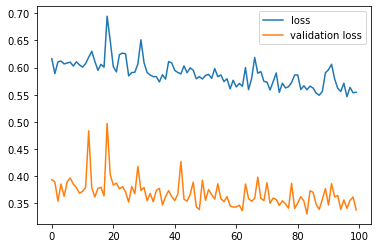

In [53]:
losses = model.history.history

plt.plot(losses["loss"])
plt.plot(losses["val_loss"])

plt.legend(["loss","validation loss"])

In [54]:
from sklearn.metrics import confusion_matrix, classification_report
predictions = np.argmax(model.predict(X_test), axis=-1)

<AxesSubplot:>

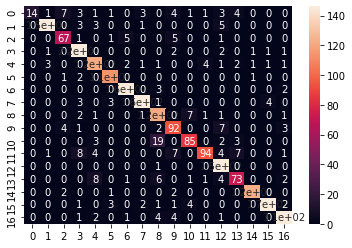

In [55]:
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),predictions), robust=True,annot=True)

In [56]:
print(classification_report(np.argmax(y_test,axis=1),predictions))

              precision    recall  f1-score   support

           0       1.00      0.33      0.49        43
           1       0.96      0.92      0.94       159
           2       0.83      0.84      0.83        80
           3       0.90      0.96      0.93       227
           4       0.85      0.88      0.86       139
           5       0.93      0.97      0.95       118
           6       0.95      0.97      0.96       164
           7       0.95      0.93      0.94       169
           8       0.76      0.90      0.82       135
           9       0.79      0.84      0.81       109
          10       0.87      0.76      0.81       112
          11       0.93      0.75      0.83       126
          12       0.82      0.99      0.90       147
          13       0.82      0.76      0.79        96
          14       0.98      0.96      0.97       128
          15       0.97      0.92      0.94       182
          16       0.96      0.96      0.96       320

    accuracy              

In [57]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [58]:
tf.config.list_physical_devices("GPU")

[]